# Please write your name and NetID below

Name: Qiuyu (Olina) Zhu

NetID: qz258 

# CPSC 477/577: Natural Language Processing
## Homework 3: Sentiment analysis (due  **11:59pm on April 13**)
*TF: Linyong Nan*

In this homework, you'll build several classifiers that can predict a user's rating of a movie solely from the words of their review. This is called **sentiment analysis**. We'll start with some simple non-neural classifiers before moving to a neural network implementation. In the end, we'll see how state-of-the-art BERT/transformers model perform on this task. Throughout the assignment, we'll explore a few different ways to encode the text data, different modeling approaches, and assess their impacts on model performance. 

The dataset we'll be using is the Stanford Sentiment Treebank Dataset (SST), specifically, we will cast the task into a binary classification, also known as **SST-2**. 

Here's the state-of-the-art performance on **SST-2**:

https://paperswithcode.com/sota/sentiment-analysis-on-sst-2-binary

More information about SST can be found here:

https://paperswithcode.com/dataset/sst

https://huggingface.co/datasets/sst

https://nlp.stanford.edu/sentiment/ 

https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf

# Set up environment

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import spacy
from scipy import stats

pd.options.mode.chained_assignment = None #suppress warnings

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

import torch
from torchtext.legacy import data as torchtext_data
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

! pip install -qq transformers
! pip install -qq datasets
from datasets import load_dataset

import time
from collections import Counter
import psutil # for monitoring RAM usage

     |████████████████████████████████| 4.0 MB 4.3 MB/s 
     |████████████████████████████████| 895 kB 34.8 MB/s 
     |████████████████████████████████| 77 kB 4.0 MB/s 
     |████████████████████████████████| 596 kB 23.8 MB/s 
     |████████████████████████████████| 6.6 MB 22.4 MB/s 
     |████████████████████████████████| 325 kB 4.3 MB/s 
     |████████████████████████████████| 1.1 MB 38.0 MB/s 
     |████████████████████████████████| 212 kB 51.6 MB/s 
     |████████████████████████████████| 136 kB 50.6 MB/s 
     |████████████████████████████████| 127 kB 50.3 MB/s 
     |████████████████████████████████| 94 kB 3.2 MB/s 
     |████████████████████████████████| 144 kB 46.9 MB/s 
     |████████████████████████████████| 271 kB 49.0 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is

# Part A: Preprocess and explore the dataset (20 points)

First, please go through Chapter 5 of the HuggingFace course to get familiar with the preprocessing pipeline:
https://huggingface.co/course/chapter5/1?fw=pt

Note that we are loading the dataset from the HuggingFace Hub directly.

## A.1: Fill in the preprocess function (10 points)
To make our results comparable to other existing research works, we will follow the standard proprocessing approach to construct SST-2 from raw SST dataset, whose sentiment labels are continuous values from 0 to 1.

References to SST2 preprocessing procedure:

* https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf (original paper, Section 3 and 5)
* https://paperswithcode.com/dataset/sst 

Based on these two references, we will convert the 0-1 continuous label to binary label by first binning the continuous value to 5 categories: negative, somewhat negative, neutral, somewhat positive or positive. Then we convert negative and somewhat negative to 0, positive and somewhat positive to 1, while discarding the neutral data instances. After preprocessing, you should expect the numbers of instances in train/validation/test splits to be: 6920/872/1821.

We use Huggingface datasets pacakge throughout this assignment. The dataset object can be considered as a large matrix, each row corresponds to a data instance, and each column corresponds to your feature or resource (such as text, tokenized_text, continuous_label, binary_label, etc.). We add or adjust columns using the **map()** function, and delete rows using the **filter()** function. More information about these two functions can be found here:

https://huggingface.co/course/chapter5/3?fw=pt

Hint: 
* First overwrite the column "label" with the corresponding binary labels (neural instances set to -1), then delete instances whose label is -1 using filter function.

In [ ]:
dataset = load_dataset("sst")

def preprocess(example):
    if example["label"] >= 0.6: example["label"] = 1
    elif example["label"] <= 0.4: example["label"] = 0
    else: example["label"] = -1 
    return example 

dataset = dataset.map(preprocess, num_proc=8, remove_columns=["tree"]) # we are not going to use the `tree` column
sst2 = dataset.filter(lambda x: x["label"] != -1)

No config specified, defaulting to: sst/default


Generating train split:   0%|          | 0/8544 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1101 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2210 [00:00<?, ? examples/s]

Dataset sst downloaded and prepared to /root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

#0:   0%|          | 0/1068 [00:00<?, ?ex/s]

#2:   0%|          | 0/1068 [00:00<?, ?ex/s]

#1:   0%|          | 0/1068 [00:00<?, ?ex/s]

#3:   0%|          | 0/1068 [00:00<?, ?ex/s]

#4:   0%|          | 0/1068 [00:00<?, ?ex/s]

#5:   0%|          | 0/1068 [00:00<?, ?ex/s]

#6:   0%|          | 0/1068 [00:00<?, ?ex/s]

#7:   0%|          | 0/1068 [00:00<?, ?ex/s]

#0:   0%|          | 0/138 [00:00<?, ?ex/s]

#1:   0%|          | 0/138 [00:00<?, ?ex/s]

#3:   0%|          | 0/138 [00:00<?, ?ex/s]

#2:   0%|          | 0/138 [00:00<?, ?ex/s]

#5:   0%|          | 0/137 [00:00<?, ?ex/s]

#4:   0%|          | 0/138 [00:00<?, ?ex/s]

#6:   0%|          | 0/137 [00:00<?, ?ex/s]

#7:   0%|          | 0/137 [00:00<?, ?ex/s]

#0:   0%|          | 0/277 [00:00<?, ?ex/s]

#1:   0%|          | 0/277 [00:00<?, ?ex/s]

#2:   0%|          | 0/276 [00:00<?, ?ex/s]

#3:   0%|          | 0/276 [00:00<?, ?ex/s]

#4:   0%|          | 0/276 [00:00<?, ?ex/s]

#5:   0%|          | 0/276 [00:00<?, ?ex/s]

#6:   0%|          | 0/276 [00:00<?, ?ex/s]

#7:   0%|          | 0/276 [00:00<?, ?ex/s]

  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

In [ ]:
sst2 

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'tokens'],
        num_rows: 6920
    })
    validation: Dataset({
        features: ['sentence', 'label', 'tokens'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'tokens'],
        num_rows: 1821
    })
})

## A.2: Explore the dataset (10 points)

Make up to 4 plots (any format) that show some relationships between the text of the review and the sentiment. Some things you may wish to explore are whether the length of the review has any bearing on the sentiment, how many good and bad reviews there are, etc. Feel free to explore the original continuous labels as well as the fine-grained labels (5 classes). In the text cell below, comment on what you've found and whether this matches your intuitions about movie reviews more generally.

We've imported matplotlib.pyplot and seaborn for your convenience.

In [ ]:
# exploring dataset 
# exploration limited to binary-label training set to avoid biasing later analysis of testing set 
train = sst2['train'] 

Text(0, 0.5, 'Sentiment Label')

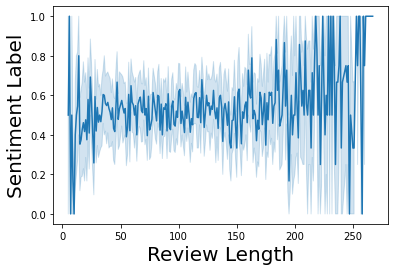

In [ ]:
# exploring whether the length of the review has any bearing on the sentiment 
review_lengths = [len(train[i]["sentence"]) for i in range(len(train))]
review_sentiments = [train[i]["label"] for i in range(len(train))]
#Figure 1
p = sns.lineplot(x=review_lengths, y=review_sentiments)
p.set_xlabel("Review Length", fontsize = 20)
p.set_ylabel("Sentiment Label", fontsize = 20) 

No config specified, defaulting to: sst/default
Reusing dataset sst (/root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff)


  0%|          | 0/3 [00:00<?, ?it/s]

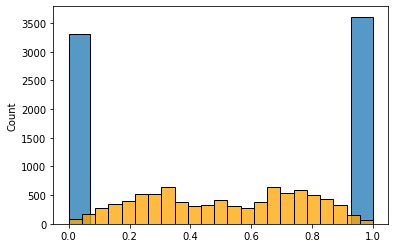

In [ ]:
# exploring number of good and bad reviews 
# plotting continuous labels as comparison 
dataset = load_dataset("sst") 
train_cont = dataset['train'] 
review_sentiments_cont = [train_cont[i]["label"] for i in range(len(train_cont))] 
# Figure 2
sns.histplot(review_sentiments)
sns.histplot(review_sentiments_cont, color='orange')

In [ ]:
# exploring the 10 most common tokens in reviews with label '0' (negative) after removing stopwords and non-alphabet characters
reviews = pd.DataFrame.from_dict(data=sst2['train']) 
negative_reviews = reviews[reviews['label']==0.0]
negative_tokens = negative_reviews['tokens'] 
neg_token_count = {} 

from nltk.corpus import stopwords
nltk.download('stopwords') 

for t in negative_tokens: 
  tokens = t.split('|')
  for i in tokens: 
    i = i.lower() 
    if i.isalpha() and i not in stopwords.words(): 
      if i not in neg_token_count: 
        neg_token_count[i] = 1
      neg_token_count[i] += 1 

top_ten_neg_tokens = sorted(neg_token_count.items(), key=lambda x: x[1], reverse=True)[:10] 
top_ten_neg_tokens 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[('movie', 461),
 ('film', 396),
 ('like', 256),
 ('bad', 134),
 ('much', 129),
 ('story', 127),
 ('even', 125),
 ('characters', 107),
 ('time', 103),
 ('would', 99)]

Text(0.5, 0, 'Top 10 Negative Tokens')

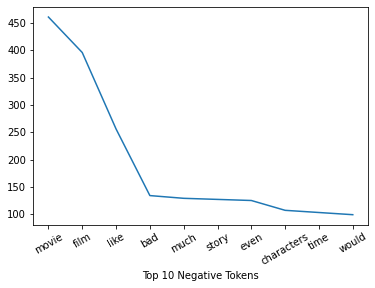

In [ ]:
# plotting in linegraph 
# Figure 3
tokens = [i[0] for i in top_ten_neg_tokens]
counts = [i[1] for i in top_ten_neg_tokens]
df_top_ten_neg_tokens = pd.DataFrame(data=list(zip(tokens, counts)), columns=('Count', 'Token'))
df_top_ten_neg_tokens.set_index('Token')
p = sns.lineplot(data=df_top_ten_neg_tokens, legend=False)
p.set_xticks(range(len(tokens)))
p.set_xticklabels(tokens, rotation = 30) 
p.set_xlabel("Top 10 Negative Tokens", fontsize = 10)

In [ ]:
# exploring the 10 most common tokens in reviews with label '1' (positive) after removing stopwords and non-alphabet characters
# runtime also noted 
import timeit
start = timeit.default_timer()
reviews = pd.DataFrame.from_dict(data=train) 
positive_reviews = reviews[reviews['label']==1.0]
positive_tokens = positive_reviews['tokens'] 
pos_token_count = {} 

for t in positive_tokens: 
  tokens = t.split('|')
  for i in tokens: 
    i = i.lower() 
    if i.isalpha() and i not in stopwords.words(): 
      if i not in pos_token_count: 
        pos_token_count[i] = 1
      pos_token_count[i] += 1 

top_ten_pos_tokens = sorted(pos_token_count.items(), key=lambda x: x[1], reverse=True)[:10] 
end = timeit.default_timer()
pos_tokens_runtime = end - start
print("The runtime is:", pos_tokens_runtime)  
top_ten_pos_tokens 

The runtime is: 331.3909336759998


[('film', 562),
 ('movie', 349),
 ('story', 164),
 ('like', 159),
 ('good', 130),
 ('funny', 130),
 ('comedy', 118),
 ('love', 110),
 ('best', 107),
 ('us', 100)]

Text(0.5, 0, 'Top 10 Positive Tokens')

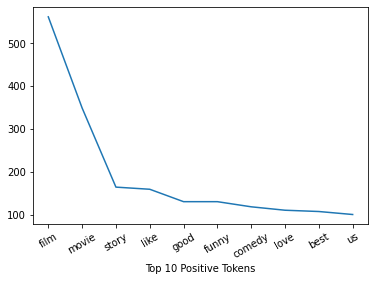

In [ ]:
# plotting in linegraph 
# Figure 4
tokens = [i[0] for i in top_ten_pos_tokens]
counts = [i[1] for i in top_ten_pos_tokens]
df_top_ten_pos_tokens = pd.DataFrame(data=list(zip(tokens, counts)), columns=('Count', 'Token'))
df_top_ten_pos_tokens.set_index('Token')
p = sns.lineplot(data=df_top_ten_pos_tokens, legend=False)
p.set_xticks(range(len(tokens)))
p.set_xticklabels(tokens, rotation = 30) 
p.set_xlabel("Top 10 Positive Tokens", fontsize = 10)

**TODO**: 

**Figure 1:** There seems to be a bimodal relationship between review length and sentiment type (positive/label=1.0, negative/label=0.0). The figure shows that both extremely short and extremely long reviews tend to have strong sentiments, whereas lengths that are not as extreme tend to be more neutral. This is consistent with my hypothesis because, intuitively, 1) less words communicate less complexity, hence the sentiment is likely purely positive or negative, and 2) those with strong feelings about the movie might write longer reviews to express their opinions or points of views, wuch as a brief essay to analyze the movie's facinating features or a long rant of how poorly some actor/actress did. 

**Figure 2:** From the blue columns (binary-label), one could see that there is roughly the same number of positive and negative reviews. The orange columns (continuous-label) show a relatively symmetric, bimodal distribution of sentiment, and the symmetry explains the similarity of the binary-label counts of each sentiment. This is also consistent with my intuition, particularly the orange columns, because people who take the time and energy to leave reviews tend to have some stronger feelings that they wish to express, rather than simply to analyze both the good and bad sides of the movie, therefore the dip in the neutral range and modes in the extremities. 

**Figure 3:** The figure shows that the top ten most common tokens, after removing stopwords and punctuation, in negative sentiments of the binary-labelled training dataset are: [('movie', 461), ('film', 396), ('like', 256), ('bad', 134), ('much', 129), ('story', 127), ('even', 125), ('characters', 107), ('time', 103), ('would', 99)]. The words 'bad', 'movie', and 'film' are expected, whereas the word 'like' is unexpected. It also seems that many words that are irrelevant but not stopwords populated the list to make it less informative. 

**Figure 4:** The figure shows that the top ten most common tokens, after removing stopwords and punctuation, in positive sentiments of the binary-labelled training dataset are: [('film', 562),  ('movie', 349),  ('story', 164),  ('like', 159),  ('good', 130),  ('funny', 130),  ('comedy', 118),  ('love', 110),  ('best', 107),  ('us', 100)]. The words 'good', 'movie', 'film', 'like', 'funny', 'love', and 'best' are expected. 

# Part B: Compare different encodings and non-neural models (50 points)

## B.1: Prepare encodings (10 points) 

Convert the text of each review to following encodings and add them as new columns to the dataset:
1. Bag of words
2. Bag of bigrams
3. Word embeddings

For Bag-of-words encoding, you should use a vocabulary size that is the minimum of 2001 and the number of unique tokens shown in the train split of SST2.
The number of 2001 corresponds to the 2000 most common tokens and an extra one for any words that do not match those tokens (think of these like the `RARE_WORDS` from Homework 1.) 

The maximum vocab size for Bag-of-Bigrams encoding is 5001 (5000 most common bigrams and 1 for all other rare words). 

**Word embeddings** are large vectors that aim to capture some kind of semantic information about the words. As such, you might expect to find similar words close to each other in word embedding vector space. We're going to be using the spacy word embeddings in this assignment. The line below loads up the spacy model, then the word embeddings of a sentence can be obtained using `spacy_model(sentence).vector`.

Hint: 
* `tokens` column of the sst2 dataset provides tokenization of the sentence already (in `str`), feel free to convert it to `list` by overwriting it.  

Note:
* loading pretrained word embeddings for all sentences could take a while
* remember to save the dataset after this step to Google Drive, such that you don't need to run this repeatedly (script provided)

In [ ]:
!python -m spacy download en_core_web_md
import en_core_web_md
spacy_model = en_core_web_md.load()

     |████████████████████████████████| 96.4 MB 1.3 MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.2.5-py3-none-any.whl size=98051301 sha256=c736bc6434e1adc9e8de0918cc0767bcda709140e35e9fed418e4d4c1617cfd1
  Stored in directory: /tmp/pip-ephem-wheel-cache-4cd6d8d3/wheels/69/c5/b8/4f1c029d89238734311b3269762ab2ee325a42da2ce8edb997
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [ ]:
RARE_SYMBOL = "[UNK]" 

# extracting all tokens and bigrams from string in sst2 train split 
# into a single list of individual tokens/bigrams   
token_strs = sst2['train']['tokens'] 
tokens = [] 
bigrams = []
for i in token_strs: 
  token = i.split("|") 
  for j in range(len(token)-1): 
    bigrams.append((token[j], token[j+1])) 
  tokens.extend(token) 

# process CBOW 
# use Collections.Counter to find dictionary of token counts in dataset 
# sort descending and take key of first 2000 entries as vocab 
BOW_vocab_dict = Counter(tokens)
BOW_vocab = sorted(BOW_vocab_dict.items(), key=lambda x: x[1], reverse=True)[:2000] 
BOW_vocab = [i[0] for i in BOW_vocab]

# process BOB 
# use Collections.Counter to find dictionary of bigram counts in dataset 
# sort descending and take key of first 5000 entries as vocab 
BOB_vocab_dict = Counter(bigrams) 
BOB_vocab = sorted(BOB_vocab_dict.items(), key=lambda x: x[1], reverse=True)[:5000]
BOB_vocab = [i[0] for i in BOB_vocab] 


def prepare_encodings(example): 
    # get words/bigrams/sentence for each row in dataset 
    token_list = example['tokens'].split("|") 
    bigram_list = [(token_list[i], token_list[i+1]) for i in range(len(token_list)-1)]
    sent = example['sentence'] 

    # create list of size 2000 (5000) for counts of tokens (bigrams) in sentence that is also in vocab 
    # use spacy_model on sentence 
    CBOW = [token_list.count(i) for i in BOW_vocab] 
    BOB = [bigram_list.count(i) for i in BOB_vocab] 
    WE = spacy_model(sent).vector 

    # add the total number of tokens (bigrams) in sentence that is not in vocabulary to end of CBOW list 
    # corresponding to RARE_SYMBOL count 
    # obtaining total list length of 2001 (5001) 
    CBOW.append(sum([1 for i in token_list if i not in BOW_vocab])) 
    BOB.append(sum([1 for i in bigram_list if i not in BOB_vocab])) 

    # add new columns to datasets by returning mapping that creates   
    # new columns where value is integer list of correct size 
    # and each element is the count of corresponding vocab in sentence 
    return {"CBOW": CBOW, "Bag of Bigrams": BOB, "Word Embedding": WE}

In [ ]:
# moved from above cell to here 
# to reduce runtime when restarting runtime 
# could just skip this cell and load from gdrive if not first time running this portion 
sst2 = sst2.map(prepare_encodings, num_proc=8) 

In [ ]:
# add RARE_SYMBOL to vocabulary list end 
# obtaining total list length of 2001 (5001) 
BOB_vocab.append(RARE_SYMBOL) 
BOW_vocab.append(RARE_SYMBOL)

**Save dataset to Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
gdrive_home = "/content/gdrive/My Drive/"
your_path = "Colab Notebooks/CPSC577/" 

sst2.save_to_disk(gdrive_home+your_path+"sst2")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Load preprocessed dataset from GDrive instead of generating them repeatedly**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
gdrive_home = "/content/gdrive/My Drive/"
your_path = "Colab Notebooks/CPSC577/" 

from datasets import load_from_disk
sst2 = load_from_disk(gdrive_home+your_path+"sst2")

Mounted at /content/gdrive


## B.2: Compare different encodings with Logistic Regression model (10 points)

Train Logistic Regression model on different types of encoding: Bag-of-Word encoding, Bag-of-Bigram encoding, Spacy word-embeddings.

We've imported the `LogisticRegression` model from scikit-learn function for your convenience.

Compare how different encodings affect the performance of the Logistic Regression model. Print the accuracy scores for train, validation and test splits.

Why do you think this is the case?

In [ ]:
# Pandas/numpy objects are used in scikit-learn instead of the arrow object that is used in huggingface, so we set the format to pandas
sst2.set_format("pandas") 
LR_model = LogisticRegression() 

# training split CBOW 
x_train_CBOW = np.stack(sst2['train']['CBOW'])
y_train = sst2['train']['label'] 
LR_model.fit(x_train_CBOW, y_train)
score_CBOW = LR_model.score(x_train_CBOW, y_train)
print("CBOW training set accuracy is:", score_CBOW)

CBOW training set accuracy is: 0.8793352601156069


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
# testing and validation splits CBOW 
y_test = sst2['test']['label']
y_val = sst2['validation']['label']
score_CBOW_test = LR_model.score(np.stack(sst2['test']['CBOW']), y_test)
score_CBOW_val = LR_model.score(np.stack(sst2['validation']['CBOW']), y_val)
print("CBOW testing set accuracy is:", score_CBOW_test) 
print("CBOW validation set accuracy is:", score_CBOW_val)

CBOW testing set accuracy is: 0.7688083470620538
CBOW validation set accuracy is: 0.7511467889908257


In [ ]:
# training split BOB 
x_train_BOB = np.stack(sst2['train']['Bag of Bigrams'])
LR_model.fit(x_train_BOB, y_train) 
score_BOB = LR_model.score(x_train_BOB, y_train)
print("Bag of Bigrams training set accuracy is:", score_BOB)

Bag of Bigrams training set accuracy is: 0.9082369942196532


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
# testing and validation splits BOB  
score_BOB_test = LR_model.score(np.stack(sst2['test']['Bag of Bigrams']), y_test)
score_BOB_val = LR_model.score(np.stack(sst2['validation']['Bag of Bigrams']), y_val)
print("BOB testing set accuracy is:", score_BOB_test) 
print("BOB validation set accuracy is:", score_BOB_val)

BOB testing set accuracy is: 0.6891817682591982
BOB validation set accuracy is: 0.6892201834862385


In [ ]:
# training split WE 
x_train_WE = np.stack(sst2['train']['Word Embedding'])
LR_model.fit(x_train_WE, y_train) 
score_WE = LR_model.score(x_train_WE, y_train)
print("Bag of Bigrams training set accuracy is:", score_WE)

Bag of Bigrams training set accuracy is: 0.8151734104046243


In [ ]:
# testing and validation splits WE   
score_WE_test = LR_model.score(np.stack(sst2['test']['Word Embedding']), y_test)
score_WE_val = LR_model.score(np.stack(sst2['validation']['Word Embedding']), y_val)
print("WE testing set accuracy is:", score_WE_test) 
print("WE validation set accuracy is:", score_WE_val)

WE testing set accuracy is: 0.814936847885777
WE validation set accuracy is: 0.7947247706422018


**TODO:** 

CBOW testing set accuracy is: 0.7688083470620538 

CBOW validation set accuracy is: 0.7511467889908257 

Bag of Bigrams testing set accuracy is: 0.6891817682591982 

Bag of Bigrams validation set accuracy is: 0.6892201834862385 

Spacy Word Embedding testing set accuracy is: 0.814936847885777 

Spacy Word Embedding validation set accuracy is: 0.7947247706422018 

Note that the training accuracies of CBOW, Bag of Bigrams, and Spacy Word Embedding are 0.8793352601156069, 0.9082369942196532, and 0.8151734104046243 respectively. 

From the above, we can see that the best performance model is the Spacy Word Embedding model, followed by CBOW and then Bag of Bigrams. The latter two is surprising as Bag of Words is essentially using unigrams, whereas Bag of Bigrams uses bigrams, and the latter is generally known for better prediction, not to mention that it could capture better context such as negation (e.g., "good" v.s. "not good"). However, this could be expected if recurring bigrams are rare, and the model cannot establish a strong connection between sentiment and bigrams. 

## B.3: Reduce the size of Bag of Words encodings (10 points)

When using Bag of Words (or Bigrams) encoding, the reviews are currently encoded in a form with thousands of features. This is potentially slowing down the runtime of our models. However, we can use dimensionality reduction techniques such as **Principal Component Analysis (PCA)** to capture the majority of the variance that we observe in our encodings but with far fewer dimensions needed.

Use PCA to perform dimensionality reduction on the **bag-of-words encodings**. Then train a **logistic regression model** using these reduced vectors. Try this on different numbers of principal components; we have provided these in the code. We have imported the PCA implementation from scikit-learn for your convenience. (Hint: the PCA `fit` and `transform` functions might be useful). 


Plot the testset performance of your different encodings in a bar plot. How does the performance of the reduced vectors compare with the original?

In [ ]:
n_components = [10, 50, 100, 300, 800]
LR_test_accuracies = [] 
LR = LogisticRegression() 
# perform PCA on bag of words using the numbers of components above and explore how this affects logistic regression model performance
for n in n_components:
  # dimensionality reduction in CBOW train and test 
    pca = PCA(n_components=n) 
    pca.fit(np.stack(sst2['train']['CBOW']))
    train_X = pca.transform(np.stack(sst2['train']['CBOW'])) 
    test_X = pca.transform(np.stack(sst2['test']['CBOW'])) 

    print("n_components =", n) 
  # run logistic regression on CBOW
    # train 
    train_Y = sst2['train']['label'] 
    LR_model.fit(train_X, train_Y) 
    score_train = LR_model.score(train_X, train_Y)
    print("CBOW training set accuracy is:", score_train) 
    # test 
    test_Y = sst2['test']['label'] 
    score_test = LR_model.score(test_X, test_Y) 
    print("CBOW testing set accuracy is:", score_test) 
    LR_test_accuracies.append(score_test) 

n_components = 10
CBOW training set accuracy is: 0.5697976878612717
CBOW testing set accuracy is: 0.5848434925864909
n_components = 50
CBOW training set accuracy is: 0.6267341040462427
CBOW testing set accuracy is: 0.6293245469522241
n_components = 100
CBOW training set accuracy is: 0.6761560693641618
CBOW testing set accuracy is: 0.6644700713893466
n_components = 300
CBOW training set accuracy is: 0.7369942196531792
CBOW testing set accuracy is: 0.7270730367929709
n_components = 800
CBOW training set accuracy is: 0.817485549132948
CBOW testing set accuracy is: 0.7534321801208127


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Text(0.5, 0, 'N_Components')

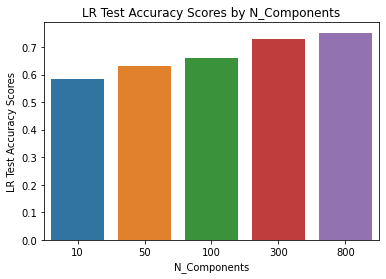

In [ ]:
# plot accuracies on a bargraph 
plt = sns.barplot(x=n_components, y=LR_test_accuracies) 
plt.set(title='LR Test Accuracy Scores by N_Components')
plt.set_ylabel('LR Test Accuracy Scores') 
plt.set_xlabel('N_Components')

**TODO:** 

It seems that the testing accuracy scorse for CBOW after PCA dimentionality reduction is strongly positively correlated to the number of n_components: the higher the number of components, the greater the accuracy. The original CBOW testing set accuracy is 0.7688083470620538 and is slightly higher compared to the highest among reduced dimensionality (n_components = 800) score of 0.7517847336628226. 

## B.4: Analysis of LR model with Bag of Words/Bag of Bigrams encodings (10 points)


We're going to see which words/bigrams were most important to the **logistic regression models** for the binary classification task sst2. Find out the words/bigrams that correspond to the 20 coefficients in the logistic regression model with the highest absolute value. (To get the coefficients for the model you trained, you can use `model.coef_`.)

Next, plot these 20 coefficients (with their original sign) in a stem plot. Label each vertical line with the word/bigram to which it corresponds. What do you notice about the relationship between the words and the bars? Add your observation in the text cell below.

In [ ]:
LR_CBOW = LogisticRegression() 
LR_BOB = LogisticRegression() 
# CBOW 
train_X = np.stack(sst2['train']['CBOW']) 
train_Y = sst2['train']['label'] 
LR_CBOW.fit(train_X, train_Y) 

# BOB
train_X = np.stack(sst2['train']['Bag of Bigrams']) 
train_Y = sst2['train']['label'] 
LR_BOB.fit(train_X, train_Y) 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression()

In [ ]:
# helper function to return list of indices of highest absolute value coefficients 
def find_sorting(c_list):
  # original index of 20 most positive coefficients 
  high = (-c_list).argsort()[:20]
  # original index of 20 most negative coefficients 
  low = c_list.argsort()[20:]
  ind_list = []

  # twenty iterations 
  for i in range(20): 
    # if abs value of most positive coef > abs value of most negative coef 
    if abs(c_list[high[0]]) > abs(c_list[low[0]]): 
      ind_list.append(high[0])
      # pop item 
      high = high[1:] 

    # if abs value of most positive coef < abs value of most negative coef 
    elif abs(c_list[high[0]]) < abs(c_list[low[0]]): 
      ind_list.append(low[0])
      # pop item 
      low = low[1:] 

    # if abs value of most positive coef = abs value of most negative coef 
    else: 
      ind_list.append(high[0])
      ind_list.append(low[0]) 
      # pop items 
      high = high[1:] 
      low = low[1:] 

  return ind_list   

In [ ]:
# using indices to find the abs and original values of 20 coefficients   
c_list = LR_CBOW.coef_[0]
CBOW_indices = find_sorting(c_list) 
CBOW_abs_coef = [abs(c_list[i]) for i in CBOW_indices]
CBOW_org_coef = [c_list[i] for i in CBOW_indices]
print(CBOW_indices)
print(CBOW_abs_coef)
print(CBOW_org_coef)

[391, 528, 365, 639, 486, 148, 393, 1003, 840, 508, 96, 403, 973, 635, 586, 473, 669, 354, 1141, 338]
[2.262935468448092, 2.0825886696489566, 2.036168301880019, 1.9802426127629589, 1.8842340339842976, 1.7523660744748402, 1.7101257665716116, 1.6972990004496984, 1.6649026278642296, 1.6217713021884286, 1.612857505128406, 1.5859983394821624, 1.5661974857693775, 1.5647429331748486, 1.5481401903609389, 1.545035287856967, 1.5348757564143996, 1.5308793765775408, 1.5298654890312555, 1.5291233345578246]
[2.262935468448092, 2.0825886696489566, 2.036168301880019, 1.9802426127629589, 1.8842340339842976, 1.7523660744748402, 1.7101257665716116, 1.6972990004496984, 1.6649026278642296, 1.6217713021884286, -1.612857505128406, 1.5859983394821624, -1.5661974857693775, -1.5647429331748486, 1.5481401903609389, -1.545035287856967, -1.5348757564143996, 1.5308793765775408, -1.5298654890312555, 1.5291233345578246]


In [ ]:
b_list = LR_BOB.coef_[0]
BOB_indices = find_sorting(b_list) 
BOB_abs_coef = [abs(b_list[i]) for i in BOB_indices]
BOB_org_coef = [b_list[i] for i in BOB_indices]
print(BOB_indices)
print(BOB_abs_coef)
print(BOB_org_coef)

[175, 400, 256, 390, 443, 79, 122, 296, 446, 264, 744, 905, 494, 515, 1032, 638, 1204, 1088, 1816, 2028]
[2.032888878981529, 1.6785658186618064, 1.647124241761521, 1.4835076265824183, 1.4787567169927185, 1.4503225087526286, 1.440434685204677, 1.3619116036225152, 1.3414681355618991, 1.3309364316914962, 1.3028176860382663, 1.3014288887129297, 1.2731403902440133, 1.2713787351300703, 1.2631379648089875, 1.2621709196606976, 1.2614569080029918, 1.2505298044412965, 1.2411769054986386, 1.2382573328054154]
[2.032888878981529, 1.6785658186618064, 1.647124241761521, 1.4835076265824183, 1.4787567169927185, 1.4503225087526286, 1.440434685204677, 1.3619116036225152, 1.3414681355618991, 1.3309364316914962, 1.3028176860382663, 1.3014288887129297, 1.2731403902440133, 1.2713787351300703, 1.2631379648089875, 1.2621709196606976, 1.2614569080029918, 1.2505298044412965, 1.2411769054986386, 1.2382573328054154]


In [ ]:
# get corresponding words and bigrams 
important_words = [BOW_vocab[i] for i in CBOW_indices] 
important_bigrams = [BOB_vocab[i] for i in BOB_indices] 
print(important_words)
print(important_bigrams)

['solid', 'remarkable', 'powerful', 'appealing', 'hilarious', 'fun', 'rare', 'refreshing', 'treat', 'terrific', 'bad', 'summer', 'pointless', 'contrived', 'brilliant', 'TV', 'barely', 'sweet', 'bore', 'enjoyable']
[('portrait', 'of'), ('but', 'also'), ('documentary', '.'), ('heart', '.'), ('with', 'such'), ('the', 'best'), ('look', 'at'), ('funny', 'and'), ('cinema', '.'), ('fun', '.'), ('a', 'powerful'), ('The', 'best'), ('even', 'if'), ('is', 'still'), ('performance', 'by'), ('a', 'solid'), ('I', 'liked'), ('family', '.'), ('us', 'with'), ('comedies', '.')]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


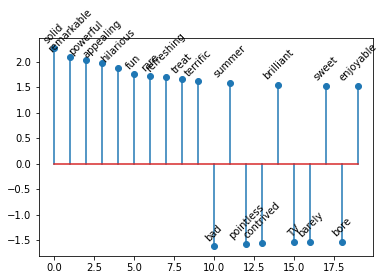

In [ ]:
# plot CBOW original coefficients  
CBOW_plt = plt.stem(CBOW_org_coef) 
for i in range(20):
    plt.annotate(important_words[i], xy=(i,CBOW_org_coef[i]), xytext=(0,5), textcoords='offset points', ha='center', rotation=45)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


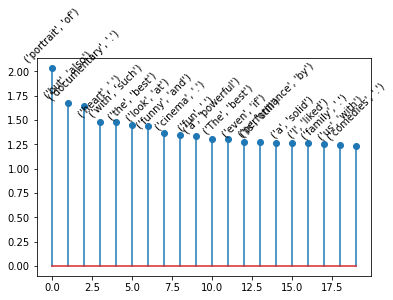

In [ ]:
# plot BOB coefficients  
BOB_plt = plt.stem(BOB_org_coef) 
for i in range(20):
    plt.annotate(important_bigrams[i], xy=(i,BOB_org_coef[i]), xytext=(0,5), textcoords='offset points', ha='center', rotation=45)

**TODO:** 

From the above, it seems that for LR on CBOW, the most important words are either strongly positive or stronly negative, yet positive words seem to be overall more important than negative words. The 20 words are, in order from most important to least: 'solid', 'remarkable', 'powerful', 'appealing', 'hilarious', 'fun', 'rare', 'refreshing', 'treat', 'terrific', 'bad', 'summer', 'pointless', 'contrived', 'brilliant', 'TV', 'barely', 'sweet', 'bore', and 'enjoyable'.

For LR on Bag of Bigrams, the negative bigrams seemed to play little role in the model, as negative coefficients are not among the top 20 absolute values. However, considering the list of bigrams from highest to lowest coefficient below, it does not seem to be ordered in descending order of importance or show much about sentiment, as punctuation seemed to take up significant volume: 
('portrait', 'of'), ('but', 'also'), ('documentary', '.'), ('heart', '.'), ('with', 'such'), ('the', 'best'), ('look', 'at'), ('funny', 'and'), ('cinema', '.'), ('fun', '.'), ('a', 'powerful'), ('The', 'best'), ('even', 'if'), ('is', 'still'), ('performance', 'by'), ('a', 'solid'), ('I', 'liked'), ('family', '.'), ('us', 'with'), and ('comedies', '.'). 

## B.5: Non-neural model comparison (10 points)

Run the classification again using three different models: **K-nearest Neighbors (with 5 neighbors)**, **Gaussian Naive Bayes** and **Support Vector Classifier**. Compare these models using all three encoding methods. All of these have been imported from scikit-learn. Print the accuracy scores for train, validation and test splits.

Which model performed best? Can you speculate why this was the case? You may provide feature importance plots/figures where appropriate.

In [ ]:
# preparing input 
CBOW_train_X = np.stack(sst2['train']['CBOW']) 
CBOW_test_X = np.stack(sst2['test']['CBOW']) 
CBOW_val_X = np.stack(sst2['validation']['CBOW']) 

BOB_train_X = np.stack(sst2['train']['Bag of Bigrams']) 
BOB_test_X = np.stack(sst2['test']['Bag of Bigrams']) 
BOB_val_X = np.stack(sst2['validation']['Bag of Bigrams']) 

WE_train_X = np.stack(sst2['train']['Word Embedding']) 
WE_test_X = np.stack(sst2['test']['Word Embedding']) 
WE_val_X = np.stack(sst2['validation']['Word Embedding']) 

train_Y = sst2['train']['label'] 
test_Y = sst2['test']['label']  
val_Y = sst2['validation']['label']  

In [ ]:
# KNN
KNN = KNeighborsClassifier(n_neighbors=5) 
  # CBOW
KNN.fit(CBOW_train_X, train_Y)
KNN_CBOW_train = KNN.score(CBOW_train_X, train_Y) 
KNN_CBOW_test = KNN.score(CBOW_test_X, test_Y) 
KNN_CBOW_val = KNN.score(CBOW_val_X, val_Y) 
  # BOB 
KNN.fit(BOB_train_X, train_Y) 
KNN_BOB_train = KNN.score(BOB_train_X, train_Y) 
KNN_BOB_test = KNN.score(BOB_test_X, test_Y) 
KNN_BOB_val = KNN.score(BOB_val_X, val_Y) 
  # WE 
KNN.fit(WE_train_X, train_Y) 
KNN_WE_train = KNN.score(WE_train_X, train_Y) 
KNN_WE_test = KNN.score(WE_test_X, test_Y) 
KNN_WE_val = KNN.score(WE_val_X, val_Y) 

print("KNN CBOW train score:", KNN_CBOW_train)
print("KNN CBOW test score:", KNN_CBOW_test)
print("KNN CBOW validation score:", KNN_CBOW_val)

print("KNN Bag of Bigrams train score:", KNN_BOB_train)
print("KNN Bag of Bigrams test score:", KNN_BOB_test)
print("KNN Bag of Bigrams validation score:", KNN_BOB_val) 

print("KNN Word Embeddings train score:", KNN_WE_train)
print("KNN Word Embeddings test score:", KNN_WE_test)
print("KNN Word Embeddings validation score:", KNN_WE_val) 

KNN CBOW train score: 0.7053468208092486
KNN CBOW test score: 0.5381658429434377
KNN CBOW validation score: 0.5389908256880734
KNN Bag of Bigrams train score: 0.6773121387283237
KNN Bag of Bigrams test score: 0.5183964854475562
KNN Bag of Bigrams validation score: 0.5378440366972477
KNN Word Embeddings train score: 0.8119942196531792
KNN Word Embeddings test score: 0.7045579352004393
KNN Word Embeddings validation score: 0.713302752293578


In [ ]:
# NB
NB = GaussianNB() 
  # CBOW 
NB.fit(CBOW_train_X, train_Y)
NB_CBOW_train = NB.score(CBOW_train_X, train_Y) 
NB_CBOW_test = NB.score(CBOW_test_X, test_Y) 
NB_CBOW_val = NB.score(CBOW_val_X, val_Y) 
  # BOB 
NB.fit(BOB_train_X, train_Y) 
NB_BOB_train = NB.score(BOB_train_X, train_Y) 
NB_BOB_test = NB.score(BOB_test_X, test_Y) 
NB_BOB_val = NB.score(BOB_val_X, val_Y) 
  # WE 
NB.fit(WE_train_X, train_Y) 
NB_WE_train = NB.score(WE_train_X, train_Y) 
NB_WE_test = NB.score(WE_test_X, test_Y) 
NB_WE_val = NB.score(WE_val_X, val_Y) 

print("NB CBOW train score:", NB_CBOW_train)
print("NB CBOW test score:", NB_CBOW_test)
print("NB CBOW validation score:", NB_CBOW_val)

print("NB Bag of Bigrams train score:", NB_BOB_train)
print("NB Bag of Bigrams test score:", NB_BOB_test)
print("NB Bag of Bigrams validation score:", NB_BOB_val) 

print("NB Word Embeddings train score:", NB_WE_train) 
print("NB Word Embeddings test score:", NB_WE_test) 
print("NB Word Embeddings validation score:", NB_WE_val) 

NB CBOW train score: 0.7804913294797687
NB CBOW test score: 0.7182866556836903
NB CBOW validation score: 0.7052752293577982
NB Bag of Bigrams train score: 0.7761560693641618
NB Bag of Bigrams test score: 0.6238330587589237
NB Bag of Bigrams validation score: 0.6307339449541285
NB Word Embeddings train score: 0.7440751445086705
NB Word Embeddings test score: 0.7512355848434926
NB Word Embeddings validation score: 0.7545871559633027


In [ ]:
# SVC 
  # CBOW
SVC_CBOW = SVC(kernel='linear').fit(CBOW_train_X, train_Y) 
SVC_CBOW_train = SVC_CBOW.score(CBOW_train_X, train_Y) 
SVC_CBOW_test = SVC_CBOW.score(CBOW_test_X, test_Y) 
SVC_CBOW_val = SVC_CBOW.score(CBOW_val_X, val_Y) 
  # BOB 
SVC_BOB = SVC().fit(BOB_train_X, train_Y) 
SVC_BOB_train = SVC_BOB.score(BOB_train_X, train_Y) 
SVC_BOB_test = SVC_BOB.score(BOB_test_X, test_Y) 
SVC_BOB_val = SVC_BOB.score(BOB_val_X, val_Y) 
  # WE 
SVC_WE = SVC().fit(WE_train_X, train_Y) 
SVC_WE_train = SVC_WE.score(WE_train_X, train_Y) 
SVC_WE_test = SVC_WE.score(WE_test_X, test_Y) 
SVC_WE_val = SVC_WE.score(WE_val_X, val_Y) 

print("SVC CBOW train score:", SVC_CBOW_train)
print("SVC CBOW test score:", SVC_CBOW_test)
print("SVC CBOW validation score:", SVC_CBOW_val)

print("SVC Bag of Bigrams train score:", SVC_BOB_train)
print("SVC Bag of Bigrams test score:", SVC_BOB_test)
print("SVC Bag of Bigrams validation score:", SVC_BOB_val) 

print("SVC Word Embeddings train score:", SVC_WE_train) 
print("SVC Word Embeddings test score:", SVC_WE_test) 
print("SVC Word Embeddings validation score:", SVC_WE_val) 

SVC CBOW train score: 0.8923410404624278
SVC CBOW test score: 0.7556287753981329
SVC CBOW validation score: 0.7350917431192661
SVC Bag of Bigrams train score: 0.5651734104046243
SVC Bag of Bigrams test score: 0.5183964854475562
SVC Bag of Bigrams validation score: 0.5252293577981652
SVC Word Embeddings train score: 0.8190751445086705
SVC Word Embeddings test score: 0.8132894014277869
SVC Word Embeddings validation score: 0.7981651376146789


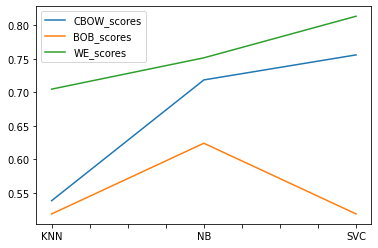

In [ ]:
# organizing test scores in [KNN, NB, SVC] format 
# plot onto graph 
CBOW_scores = [KNN_CBOW_test, NB_CBOW_test, SVC_CBOW_test]
BOB_scores = [KNN_BOB_test, NB_BOB_test, SVC_BOB_test]
WE_scores = [KNN_WE_test, NB_WE_test, SVC_WE_test] 
df_scores = pd.DataFrame({"CBOW_scores": CBOW_scores, "BOB_scores": BOB_scores, "WE_scores": WE_scores}, index=['KNN', 'NB', 'SVC']) 
df_scores.plot() 

**TODO:** 

SVC is the model that performed the best for CBOW and Spacy Word Embeddings, followed by Gaussian Naive Bayes, and lastly KNN. However, SVC performed very poorly for Bag of Bigrams, and only worked moderately with Gaussian Naive Bayes. 

 

### **Results reproduced below:** 

KNN CBOW train score: 0.7053468208092486

KNN CBOW test score: 0.5381658429434377

KNN CBOW validation score: 0.5389908256880734

KNN Bag of Bigrams train score: 0.6773121387283237

KNN Bag of Bigrams test score: 0.5183964854475562

KNN Bag of Bigrams validation score: 0.5378440366972477

KNN Word Embeddings train score: 0.8119942196531792

KNN Word Embeddings test score: 0.7045579352004393

KNN Word Embeddings validation score: 0.713302752293578

NB CBOW train score: 0.7804913294797687

NB CBOW test score: 0.7182866556836903

NB CBOW validation score: 0.7052752293577982

NB Bag of Bigrams train score: 0.7761560693641618

NB Bag of Bigrams test score: 0.6238330587589237

NB Bag of Bigrams validation score: 0.6307339449541285 

NB Word Embeddings train score: 0.7440751445086705 

NB Word Embeddings test score: 0.7512355848434926

NB Word Embeddings validation score: 0.7545871559633027 

SVC CBOW train score: 0.8923410404624278 

SVC CBOW test score: 0.7556287753981329 

SVC CBOW validation score: 0.7350917431192661 

SVC Bag of Bigrams train score: 0.5651734104046243 

SVC Bag of Bigrams test score: 0.5183964854475562 

SVC Bag of Bigrams validation score: 0.5252293577981652 

SVC Word Embeddings train score: 0.8190751445086705

SVC Word Embeddings test score: 0.8132894014277869 

SVC Word Embeddings validation score: 0.7981651376146789 

# Part C: Implement Bi-directional LSTM classifier (30 points)

Now, we're going to look at some neural methods for sentiment classification. Specifically, we'll explore how Bi-directional LSTM perform on the same task.

Load pretrained glove embeddings and prepare iterators using torchtext package

In [ ]:
seed = 1234
batch_size = 64
max_vocab_size = 25_000
word_embed_version = "glove.42B.300d" # other options: "glove.6B.100d" 

torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class DataFrameDataset(torchtext_data.Dataset):
    def __init__(self, df: pd.DataFrame, fields: list):
        super(DataFrameDataset, self).__init__([torchtext_data.Example.fromlist(list(r), fields) for i, r in df.iterrows()], fields)

TEXT = torchtext_data.Field(tokenize = 'spacy',
               tokenizer_language = 'en_core_web_sm',
               include_lengths = True)

LABEL = torchtext_data.LabelField(dtype = torch.float)

TEXT.build_vocab([TEXT.preprocess(sent) for sent in sst2["train"]["sentence"]], max_size=max_vocab_size, vectors=word_embed_version, unk_init=torch.Tensor.normal_)
LABEL.build_vocab(sst2["train"]["label"])

train_dataset = DataFrameDataset(df=pd.DataFrame({"text": sst2["train"]["sentence"], "label": sst2["train"]["label"]}), fields=(('text',TEXT),('label',LABEL)))
valid_dataset = DataFrameDataset(df=pd.DataFrame({"text": sst2["validation"]["sentence"], "label": sst2["validation"]["label"]}), fields=(('text',TEXT),('label',LABEL)))
test_dataset = DataFrameDataset(df=pd.DataFrame({"text": sst2["test"]["sentence"], "label": sst2["test"]["label"]}), fields=(('text',TEXT),('label',LABEL)))

train_iterator, valid_iterator, test_iterator = torchtext_data.BucketIterator.splits(
    (train_dataset, valid_dataset, test_dataset), 
    batch_size = batch_size,
    sort_key = lambda x: len(x.text),
    sort_within_batch = True,
    device = device) 

.vector_cache/glove.42B.300d.zip: 1.88GB [05:55, 5.28MB/s]                            
100%|█████████▉| 1917493/1917494 [04:08<00:00, 7724.57it/s]


## C.1: Fill out the LSTM_Classifier class (15 points)

The first thing you'll want to do is to fill out the code in the initialization of the classifier class. You need to define at least these three layers: self.embedding, self.lstm and self.fc. Use the built-in functions in torch.nn to accomplish this and pay attention to what each dimensions of each layer should have for its input and output (most of the dimention values are already provided). 

The next step is to implement the forward pass. Make use of the layers you defined above to create embedded, hidden and output vectors for a given input token_ids.

Hint:
* There could be muiltiple ways to connect lstm layer and fc layer, one possible solution is to pass the last hidden states of the LSTM to the fc layer. [Read more](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) 

Note:
* The BucketIterator in the previous cell takes care of many procedures that are crucial in properly training a neural network model using batches. Though we provided the codes so that you don't have to code them, it's important to understand what's happening in the background. In short, it performs bucketing and padding procedures to divide the whole dataset into batches. Sentences are all of different lengths, yet during the forward pass, we need to represent inputs of a batch as a matrix (neural networks are all about matrix multiplications), which requires all the sentences in the batch to have same length. To achieve this, we pad all sentences of a batch up to the length of the longest sentence in the batch. However, we want to minimize the number of paddings we add (to save computation), and bucketing trick makes this happen by first sorting all sentences by their lengths, then dividing them into buckets/batches and performing padding process. 
* Techniques mentioned above apply to batch training of neural networks in general. Packing is another technique specifically for training RNNs in a more efficient manner. It allows RNN to only process non-padded elements of the sequence, so that the last hidden and cell states you get are not from pad element. In your forward pass, you can call `nn.utils.rnn.pack_padded_sequence` and `nn.utils.rnn.pad_packed_sequence`. [Read more](https://stackoverflow.com/questions/51030782/why-do-we-pack-the-sequences-in-pytorch)
* When initializing the embedding layer, you need to set the padding_idx argument, so that the embedding vector of the pad symbol will not be updated during training. [Read more](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html)
* Dropout is a regularization technique for reducing overfitting on training data. Usually it's added between layers, and you can also pass it as an argument in your LSTM layer.
* Pay attention to input dimention of the fc layer, since we have a bi-directional LSTM.

In [ ]:
class LSTM_Classifier(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout, pad_idx):
        super().__init__()
        self.lstm = torch.nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout) 
        self.embedding = torch.nn.Embedding(num_embeddings=input_dim, embedding_dim=embedding_dim, padding_idx=pad_idx) 
        self.fc = torch.nn.Linear(in_features=embedding_dim, out_features=output_dim)
        self.Dropout = nn.Dropout(dropout)
        self.dimension = output_dim 
        
    def forward(self, token_ids, sent_lengths): 
        # get embeddings by passing token_ids through embedding layer 
        emb = self.embedding(token_ids) 
        
        # pack and pad embeddings to obtain same length of sents in batch 
        pack_in = nn.utils.rnn.pack_padded_sequence(emb, sent_lengths.to('cpu'), batch_first=True, enforce_sorted=False)
        pack_out, temp = self.lstm(pack_in)
        padded_emb, temp = nn.utils.rnn.pad_packed_sequence(pack_out, batch_first=True)

        # learning from two directions (forward, reverse) 
        output_forward = padded_emb[range(len(padded_emb)), (sent_lengths - 1), :self.dimension]
        output_reverse = padded_emb[:, 0, self.dimension:]

        # concatenate sequences and perform dropout to regularize output 
        output_reduced = torch.cat((output_forward, output_reverse), 1) 
        output_dropped = self.Dropout(output_reduced)

        # pass through fully connected layer 
        output_fc = self.fc(output_dropped)
        output_fc = torch.squeeze(output_fc, 1) 

        # apply sigmoid function to obtain probability of sequences 
        result = torch.sigmoid(output_fc)

        return result

Now we're going to define model hyperparameters, model, optimizer and loss function. We will initialize the embedding layer of our classifer with pretrained glove embeddings to boost the performance.

In [ ]:
# define hyperparameters
input_dim = len(TEXT.vocab)
embedding_dim = 300 if word_embed_version == "glove.42B.300d" else 100
hidden_dim = 256
output_dim = 1
bidirectional = True
n_layers = 2
dropout = 0.5
pad_idx = TEXT.vocab.stoi[TEXT.pad_token]
unk_idx = TEXT.vocab.stoi[TEXT.unk_token]

# define model
lstm_classifier = LSTM_Classifier(input_dim, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout, pad_idx)

# initialize embeddings with spacy pretrained word embeddings
pretrained_embeddings = TEXT.vocab.vectors
lstm_classifier.embedding.weight.data.copy_(pretrained_embeddings)
lstm_classifier.embedding.weight.data[pad_idx] = torch.zeros(embedding_dim)
lstm_classifier.embedding.weight.data[unk_idx] = torch.zeros(embedding_dim)

# define and setup optimization algorithm
optimizer = optim.Adam(lstm_classifier.parameters()) # use the default learning rate
criterion = torch.nn.BCEWithLogitsLoss() # this loss combines a Sigmoid layer and the BCELoss in one single class, more numerically stable

# move to GPU to accelerate the training
lstm_classifier = lstm_classifier.to(device)
criterion = criterion.to(device)

## C.2: Fill out the following functions, train and compare with Part B models (15 points)

In [ ]:
from sklearn.metrics import accuracy_score
def binary_accuracy(outputs, y):
    # return the accuracy given the LSTM output logits (outputs) and true values (y); accuracy should be a float number
    return torch.float(accuracy_score(y, outputs)) 

In [ ]:
# training function
# iterator contains batches of the training data 
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train() 
    
    for batch in iterator:
        # reset the optimiser
        optimizer.zero_grad()

        text, text_lengths = batch.text
        label = batch.label

        # make predictions
        pred = model(text, text_lengths.to('cpu')) 
        # calculate loss and accuracy
        loss = criterion(pred, label) 
        acc = binary_accuracy(pred, label)
        # backprop
        loss.backward()
        # update params
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
# evaluation function
# iterator contains batches of the training data 
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text, text_lengths = batch.text
            label = batch.label

            # make predictions
            pred = model(text, text_lengths) 
            # calculate loss 
            loss = criterion(pred, label) 
            acc = binary_accuracy(pred, label) 
            # backprop
            loss.backward() 

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

**Main training loop**

Remember to change the hardward accelerator to GPU (Edit --> Notebook Settings), then restart runtime.

Modify your scripts above to utilize GPU training: send all tensors, models, optimizers to GPU (device variable provided).


Choose the best model based on validation set performance. Feel free to try different hyperparameters.

It may take a few minutes in total.

In [ ]:
N_EPOCHS = 20

best_valid_loss = float('inf')
for epoch in range(N_EPOCHS):
    
    train_loss, train_acc = train(lstm_classifier, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(lstm_classifier, valid_iterator, criterion)
      
    # keep track of the best model, and save it
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(lstm_classifier.state_dict(), gdrive_home+your_path+'best_biLSTM_model.pt')
    print(f"\n\tEpoch: {epoch + 1}")
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

RuntimeError: ignored

**Restore the best model and evaluate on test set**

In [ ]:
lstm_classifier.load_state_dict(torch.load(gdrive_home+your_path+'best_biLSTM_model.pt'))
test_loss, test_acc = evaluate(lstm_classifier, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

**TODO**: Compare this with simple models from Part B in terms of performance, training time, model complexity, etc.


# Part D: State-of-the-art model: BERT fine-tuned classifier (0 point)

In this part, we will see how to apply pre-trained BERT model to improve text classification. You won't have to code anything for yourself here; we provide the code to serve as a learning resource.

Bidirectional Encoder Representations from Transformers (BERT) is a technique for NLP (Natural Language Processing) pre-training developed by Google. BERT was created and published in 2018 by Jacob Devlin and his colleagues from Google. Google is leveraging BERT to better understand user searches. (From WIKI)


Read more: http://jalammar.github.io/illustrated-transformer/

BERT paper: [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805)

Understanding BERT: https://towardsdatascience.com/understanding-bert-is-it-a-game-changer-in-nlp-7cca943cf3ad

As before, run the cells below. Don't modify them but do take a look at them to see what's going on.

More about Huggingface pipeline: 

https://huggingface.co/course/chapter1/1

We will load an already fine-tuned checkpoint from Huggingface Hub to save computation (we also use a lighter version of BERT called [distillBERT](https://arxiv.org/abs/1910.01108)). 

You can see how this classifier performs on our test set. More information about this fine-tuned checkpoint can be found here:

https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english

You can also compare it with other state-of-the-art model performances here:

https://paperswithcode.com/sota/sentiment-analysis-on-sst-2-binary 

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, TrainingArguments, Trainer
from datasets import load_metric

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
training_args = TrainingArguments("distilbert-base-uncased-sst2")

def tokenize_function(example):
    new_columns = tokenizer(example["sentence"], truncation=True)
    new_columns["label_ids"] = np.array(example["label"]).astype(int)
    return new_columns

sst2.reset_format()
tokenized_sst2 = sst2.map(tokenize_function, batched=True, num_proc=8, remove_columns=['sent_length', 'bow_encodings', 'bob_encodings', 'word_embeddings', 'label']) # remove unnecessary columns, you can change these according to columns you defined
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_sst2["train"],
    eval_dataset=tokenized_sst2["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

### Since we already load a fine-tuned checkpoint, no need to train again
# trainer.train()

In [ ]:
# predict on test
metric = load_metric("glue", "sst2")
predictions = trainer.predict(tokenized_sst2["test"])
preds = np.argmax(predictions.predictions, axis=-1)
result = metric.compute(predictions=preds, references=predictions.label_ids)
print(result)

# Submission instructions
1. Print this page as a **PDF** and name it `[your_NetID]_nlp_hw3.pdf`.
2. Rename your notebook `[your_NetID]_nlp_hw3.ipynb`.
3. Submit both on Canvas by **11:59pm on April 13**.